In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matplotlib.rcParams['savefig.dpi'] = 144
import seaborn

# Recommendation Engine, Session 2

In [1]:
import pandas as pd
import numpy as np
from sklearn import base
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import RidgeCV, LinearRegression, SGDRegressor, Ridge
from sklearn.decomposition import TruncatedSVD
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

In [2]:
def parse_movie_line(l):
    id_, title, cats = l.strip().split('::')
    return {'id': int(id_), 'title': title, 'year': int(title.rsplit(' ')[-1][1:-1]), 
            'categories': cats.split('|')}

with open('ml-10M100K/movies.dat', 'r') as f:
    df = pd.DataFrame([parse_movie_line(l) for l in f]).set_index('id')

def parse_rating_line(l):
    uid, mid, rating, time = l.strip().split('::')
    return {'user_id': int(uid), 'movie_id': int(mid), 'rating': float(rating)}

with open('ml-10M100K/ratings.dat', 'r') as f:
    df_ratings = pd.DataFrame([parse_rating_line(l) for l in f])

## Review

- Anything from the exercises that seems important?

## Regression methods

- Goal of estimator
- Linear regression
- Averaging with one-hot encoding
- Developing a base model without item-user interaction
- Test train split?

In [3]:
class Dictizer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col):
        self.col = col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.col].apply(lambda x: {x: 1})

In [4]:
user_dict = Pipeline([('dict', Dictizer('user_id')),
                      ('vect', DictVectorizer())])
movie_dict = Pipeline([('dict', Dictizer('movie_id')),
                       ('vect', DictVectorizer())])
union = FeatureUnion([('user_dict', user_dict),
                      ('movie_dict', movie_dict)])
lr_pipe = Pipeline([('union', union),
                    ('lr', Ridge())])

## Cross-validation

- If only one 5-star rating, don't really trust that movie should be five stars
- Bayes -- update rating with new info, but don't believe entirely
- Avoids overfitting / high-variance
- Use regularization with linear models
- Amount?  Cross-validation

In [5]:
N = 100000

In [6]:
samp = df_ratings.sample(N)

In [7]:
lr_pipe.fit(samp, samp['rating'])

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user_dict', Pipeline(steps=[('dict', Dictizer(col='user_id')), ('vect', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('movie_dict', Pipeline(steps=[('dict', Dictizer(col='movie_id')...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

Let's work with a subset, chosen from reviewers

In [9]:
users = df_ratings['user_id'].unique()

In [10]:
user_sample = np.random.choice(users, 5000)

In [11]:
df_ratings_sample = df_ratings[df_ratings['user_id'].isin(user_sample)]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_ratings_sample, df_ratings_sample['rating'])

In [13]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user_dict', Pipeline(steps=[('dict', Dictizer(col='user_id')), ('vect', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('movie_dict', Pipeline(steps=[('dict', Dictizer(col='movie_id')...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'lr__alpha': array([   0.1    ,    0.21544,    0.46416,    1.     ,    2.15443,
          4.64159,   10.     ,   21.54435,   46.41589,  100.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [14]:
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.36209872348001626, 0.32832147323110972)

In [15]:
sgd_pipe = Pipeline([('union', union),
                     ('sgd', SGDRegressor(n_iter=20))])
sgd_pipe.fit(X_train, y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('user_dict', Pipeline(steps=[('dict', Dictizer(col='user_id')), ('vect', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('movie_dict', Pipeline(steps=[('dict', Dictizer(col='movie_id')..., penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False))])

In [16]:
sgd_pipe.score(X_train, y_train), sgd_pipe.score(X_test, y_test)

(0.24821924446696986, 0.23945463114780108)

In [17]:
best = gs.best_estimator_

In [18]:
best = lr_pipe
best.named_steps['lr'].alpha = 4

In [19]:
best.fit(df_ratings, df_ratings['rating'])
base_scores = best.predict(df_ratings)

In [20]:
df_ratings['residuals'] = df_ratings['rating'] - base_scores

## Cooperative learning

- Now want something to predict residuals based on interaction of user and item
- For a given user, movie -- find users who liked movie, rate similarity to user to those
- Assume linear effect

In [24]:
class DistFromFans(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        self.by_user_ratings = X.groupby('user_id').apply(
            lambda items: {i[1]: i[2] for i in items.itertuples()})
        self.dv = DictVectorizer().fit(self.by_user_ratings)
        self.user_mat = self.dv.transform(self.by_user_ratings)
        return self
    
    def get_avg_fan(self, movie_id):
        #fans = self.by_user_ratings[by_user_ratings.apply(lambda x: x.get(movie_id) == 5)]
        #return dv.transform(fans).mean(axis=0)
        fan_inds = (self.user_mat[:, self.dv.feature_names_.index(movie_id)] == 5).toarray().reshape(-1)
        if fan_inds.any():
            return self.user_mat[fan_inds, :].mean(axis=0)
        return np.zeros([1, len(self.dv.feature_names_)])
    
    def dist_from_avg_fan(self, user_id, movie_id):
        user = self.dv.transform(self.by_user_ratings.loc[user_id])
        avg_fan = self.get_avg_fan(movie_id)
        return abs(user - avg_fan).sum()
    
    def transform(self, X):
        return X.apply(lambda x: self.dist_from_avg_fan(x['user_id'], x['movie_id']), axis=1)

In [25]:
dff = DistFromFans().fit(df_ratings)

In [26]:
dff.transform(pd.DataFrame({'user_id': [142], 'movie_id': [608]}))

0    891.427528
dtype: float64

In [27]:
samp = df_ratings.sample(1000)

In [28]:
dists = dff.transform(samp)

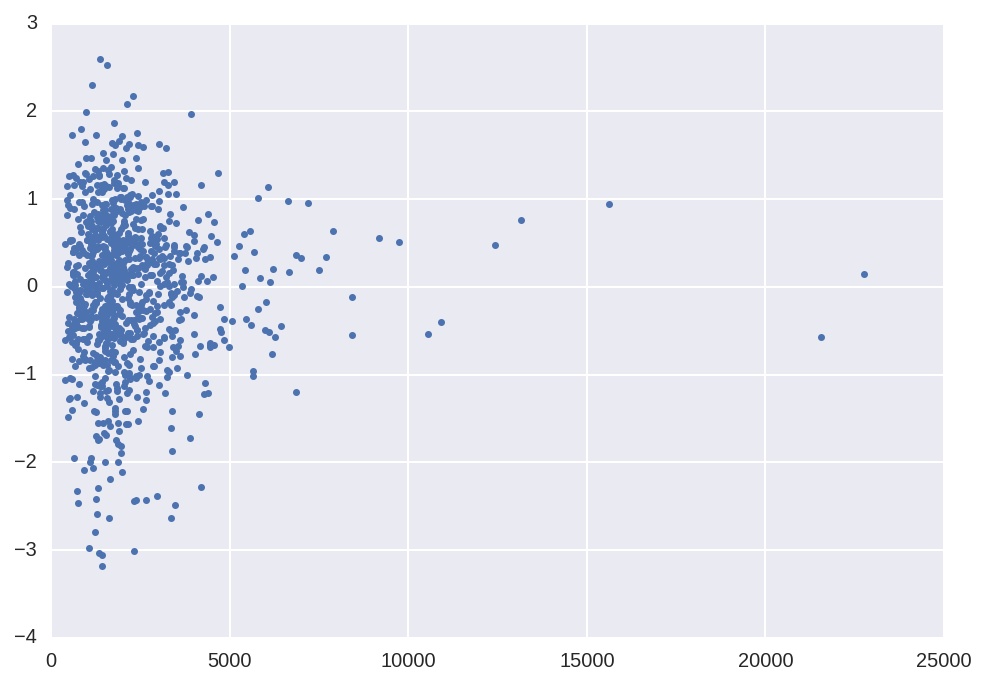

In [31]:
plt.plot(dists, samp['residuals'], '.')

In [32]:
np.cov(dists, samp['residuals'])

array([[  2.98258123e+06,   1.87026399e+01],
       [  1.87026399e+01,   7.18460484e-01]])

Pos correlation between distance and residual, which seems backwards. But large distances dominate. Using inverse distance seems to give us the expected relationship.  (Maybe.  may depend on sample.)

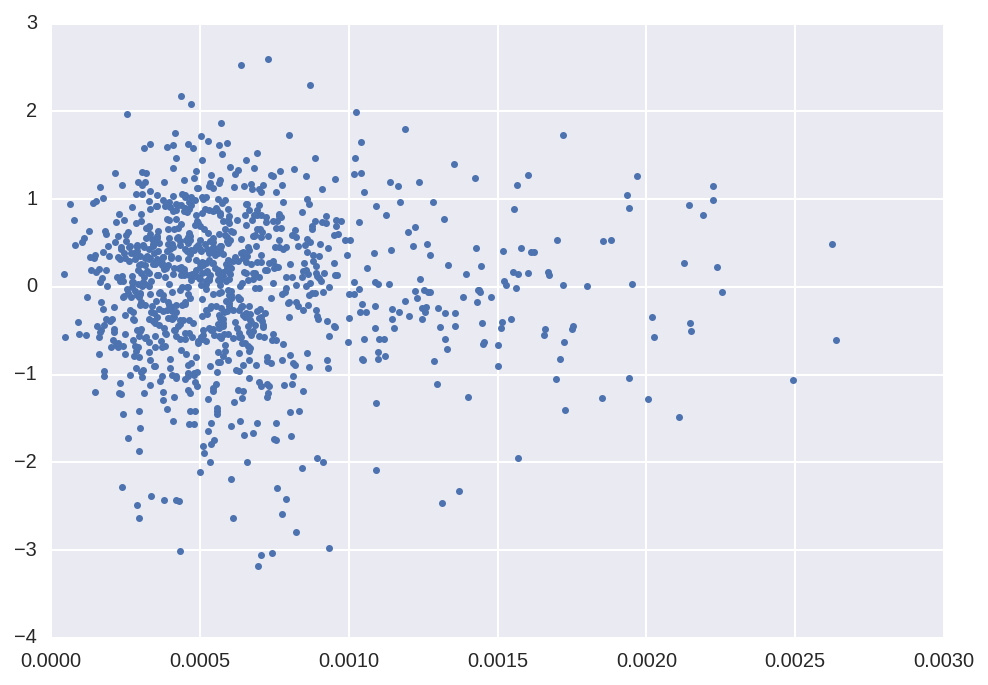

In [33]:
plt.plot(1/dists, samp['residuals'], '.')

In [34]:
np.cov(1/dists, samp['residuals'])

array([[  1.65691127e-07,  -6.11317667e-06],
       [ -6.11317667e-06,   7.18460484e-01]])

TODO:
- Turn this into a pipeline to rate movies
- Combine with movie selection scheme to actually make recommendations
- Matrix factorization algorithm?
- Deploying as a flask app?

##  Exercises

1. Add other user-item interaction models.  Random forest?  Similarity of movie to user's favorites? Blend with linear model.

2. Use GBT to blend models (following Netflix Prize model).

3. Deploy to flask app.  Give framework?